### Notebook format of original code

Code has been adjusted to not plot anything until all iterations are completed, this way we remove plotting overhead

In [11]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from functools import partial

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    train_path = '/content/drive/MyDrive/DD2358_Data/train.csv'
    test_path = '/content/drive/MyDrive/DD2358_Data/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'



#OLD CODE BEFORE CYTHON

def g(x):
    """ sigmoid function """
    return 1.0 / (1.0 + np.exp(-x))

def grad_g(x):
    """ gradient of sigmoid function """
    gx = g(x)
    return gx * (1.0 - gx)

def predict(Theta1, Theta2, X):
    """ Predict labels in a trained three-layer classification network.
    Input:
      Theta1       trained weights for layer 1 (hidden_layer_size x input_layer_size+1)
      Theta2       trained weights for layer 2 (num_labels x hidden_layer_size+1)
      X            matrix of training data (m x input_layer_size)
    Output:
      prediction   label prediction (m x 1)
    """
    m = np.shape(X)[0]     # number of training values
    num_labels = np.shape(Theta2)[0]

    a1 = np.hstack((np.ones((m,1)), X))   # add bias (input layer)
    a2 = g(a1 @ Theta1.T)                 # apply sigmoid: input --> hidden
    a2 = np.hstack((np.ones((m,1)), a2))  # add bias (hidden layer)
    a3 = g(a2 @ Theta2.T)                 # apply sigmoid: hidden --> output

    prediction = np.argmax(a3, axis=1).reshape((m,1))
    return prediction

def reshape(theta, input_layer_size, hidden_layer_size, num_labels):
    """ Reshape theta into Theta1 and Theta2, the weights of our neural network """
    ncut = hidden_layer_size * (input_layer_size+1)
    Theta1 = theta[0:ncut].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = theta[ncut:].reshape(num_labels, hidden_layer_size+1)
    return Theta1, Theta2

def cost_function(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    """ Neural net cost function for a three-layer classification network. """
    # Unflatten theta
    Theta1, Theta2 = reshape(theta, input_layer_size, hidden_layer_size, num_labels)

    # number of training values
    m = len(y)

    # Feedforward: calculate cost J
    a1 = np.hstack((np.ones((m,1)), X))
    a2 = g(a1 @ Theta1.T)
    a2 = np.hstack((np.ones((m,1)), a2))
    a3 = g(a2 @ Theta2.T)

    # One-hot encode labels
    y_mtx = 1.0 * (y == 0)
    for k in range(1, num_labels):
        y_mtx = np.hstack((y_mtx, 1.0 * (y == k)))

    # cost function
    J = np.sum(-y_mtx * np.log(a3) - (1.0 - y_mtx) * np.log(1.0 - a3)) / m

    # add regularization
    J += (lmbda/(2.0*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    return J

def gradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    """ Neural net cost function gradient for a three-layer classification network. """
    # Unflatten theta
    Theta1, Theta2 = reshape(theta, input_layer_size, hidden_layer_size, num_labels)

    m = len(y)
    Delta1 = np.zeros((hidden_layer_size, input_layer_size+1))
    Delta2 = np.zeros((num_labels, hidden_layer_size+1))

    # Backpropagation
    for t in range(m):
        # forward
        a1 = X[t,:].reshape((input_layer_size,1))
        a1 = np.vstack((1, a1))  # +bias
        z2 = Theta1 @ a1
        a2 = g(z2)
        a2 = np.vstack((1, a2))  # +bias
        a3 = g(Theta2 @ a2)

        # one-hot
        y_k = np.zeros((num_labels,1))
        y_k[int(y[t,0])] = 1
        # compute error for layer 3
        delta3 = a3 - y_k
        Delta2 += (delta3 @ a2.T)

        # compute error for layer 2
        delta2 = (Theta2[:,1:].T @ delta3) * grad_g(z2)
        Delta1 += (delta2 @ a1.T)

    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m

    # add regularization
    Theta1_grad[:,1:] += (lmbda/m) * Theta1[:,1:]
    Theta2_grad[:,1:] += (lmbda/m) * Theta2[:,1:]

    # flatten gradients
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    return grad

# --- Global Variables for Callback ---
N_iter = 1
J_min = np.inf
theta_best = None

# Lists to store metrics per iteration
Js_train = []
Js_test = []
Acc_train = []
Acc_test = []


def callbackF(input_layer_size, hidden_layer_size, num_labels, X, y, lmbda, X_val, y_val, theta_k):
    """ Callback to compute and store stats at each iteration (no real-time plotting). """
    global N_iter
    global J_min
    global theta_best
    global Js_train
    global Js_test
    global Acc_train
    global Acc_test

    # Compute training cost/accuracy
    train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    Theta1, Theta2 = reshape(theta_k, input_layer_size, hidden_layer_size, num_labels)
    y_pred_train = predict(Theta1, Theta2, X)
    train_accuracy = 100.0 * np.sum(y_pred_train == y) / len(y)

    # Compute validation cost/accuracy
    val_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X_val, y_val, lmbda)
    y_pred_val = predict(Theta1, Theta2, X_val)
    val_accuracy = 100.0 * np.sum(y_pred_val == y_val) / len(y_val)

    # Store metrics
    Js_train.append(train_cost)
    Js_test.append(val_cost)
    Acc_train.append(train_accuracy)
    Acc_test.append(val_accuracy)

    # Print iteration stats
    print(f"iter={N_iter:3d}:  "
          f"Train Cost= {train_cost:.4f}  Acc= {train_accuracy:.2f}%  |  "
          f"Val Cost= {val_cost:.4f}    Acc= {val_accuracy:.2f}%")

    # Track best
    if val_cost < J_min:
        J_min = val_cost
        theta_best = theta_k.copy()

    N_iter += 1



In [13]:
%%cython -a
# cython: boundscheck=False, wraparound=False, cdivision=True, nonecheck=False

import numpy as np
cimport numpy as np
from libc.math cimport exp

# Define C-optimized sigmoid functions that work with arrays
cpdef np.ndarray[np.float64_t, ndim=2] sigmoid(np.ndarray[np.float64_t, ndim=2] z):
    """Vectorized sigmoid function"""
    return 1.0 / (1.0 + np.exp(-z))

cpdef np.ndarray[np.float64_t, ndim=2] sigmoid_gradient(np.ndarray[np.float64_t, ndim=2] z):
    """Vectorized sigmoid gradient"""
    cdef np.ndarray[np.float64_t, ndim=2] s = sigmoid(z)
    return s * (1.0 - s)

# Scalar version of sigmoid for when we need it
cdef double sigmoid_scalar(double x) nogil:
    return 1.0 / (1.0 + exp(-x))

# Define the optimized gradient function
def gradient_cython(np.ndarray[np.float64_t, ndim=1] theta, 
                   int input_layer_size, int hidden_layer_size, int num_labels, 
                   np.ndarray[np.float64_t, ndim=2] X, 
                   np.ndarray[np.int32_t, ndim=2] y,  # Changed np.int_t to np.int32_t
                   double lmbda):
    """Optimized gradient computation for neural network"""
    
    # Get dimensions
    cdef int m = X.shape[0]
    cdef int theta1_size = hidden_layer_size * (input_layer_size + 1)
    
    # Unflatten theta into weight matrices
    cdef np.ndarray[np.float64_t, ndim=2] Theta1 = theta[:theta1_size].reshape(hidden_layer_size, input_layer_size + 1)
    cdef np.ndarray[np.float64_t, ndim=2] Theta2 = theta[theta1_size:].reshape(num_labels, hidden_layer_size + 1)
    
    # Initialize accumulators
    cdef np.ndarray[np.float64_t, ndim=2] Delta1 = np.zeros((hidden_layer_size, input_layer_size + 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] Delta2 = np.zeros((num_labels, hidden_layer_size + 1), dtype=np.float64)
    
    # Temporary arrays for the forward pass
    cdef np.ndarray[np.float64_t, ndim=2] a1 = np.zeros((input_layer_size + 1, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] z2 = np.zeros((hidden_layer_size, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] a2 = np.zeros((hidden_layer_size + 1, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] a3 = np.zeros((num_labels, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] y_k = np.zeros((num_labels, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] delta3 = np.zeros((num_labels, 1), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=2] delta2 = np.zeros((hidden_layer_size, 1), dtype=np.float64)
    
    cdef int t, j, label
    cdef double a1_val, z2_val, a2_val, a3_val
    
    # Backpropagation
    for t in range(m):
        # Forward pass - manually handle the operations to avoid temporary arrays
        
        # Input layer with bias
        a1[0, 0] = 1.0  # Bias term
        for j in range(input_layer_size):
            a1[j+1, 0] = X[t, j]
        
        # Hidden layer pre-activation
        for j in range(hidden_layer_size):
            z2_val = 0
            for k in range(input_layer_size + 1):
                z2_val += Theta1[j, k] * a1[k, 0]
            z2[j, 0] = z2_val
        
        # Hidden layer activation with bias
        a2[0, 0] = 1.0  # Bias term
        for j in range(hidden_layer_size):
            a2[j+1, 0] = sigmoid_scalar(z2[j, 0])
        
        # Output layer
        for j in range(num_labels):
            a3_val = 0
            for k in range(hidden_layer_size + 1):
                a3_val += Theta2[j, k] * a2[k, 0]
            a3[j, 0] = sigmoid_scalar(a3_val)
        
        # One-hot encoding of target
        for j in range(num_labels):
            y_k[j, 0] = 0.0
        label = y[t, 0]
        y_k[label, 0] = 1.0
        
        # Compute error for layer 3
        for j in range(num_labels):
            delta3[j, 0] = a3[j, 0] - y_k[j, 0]
        
        # Update Delta2
        for j in range(num_labels):
            for k in range(hidden_layer_size + 1):
                Delta2[j, k] += delta3[j, 0] * a2[k, 0]
        
        # Compute error for layer 2
        for j in range(hidden_layer_size):
            delta2[j, 0] = 0
            for k in range(num_labels):
                delta2[j, 0] += Theta2[k, j+1] * delta3[k, 0]
            delta2[j, 0] *= sigmoid_scalar(z2[j, 0]) * (1 - sigmoid_scalar(z2[j, 0]))
        
        # Update Delta1
        for j in range(hidden_layer_size):
            for k in range(input_layer_size + 1):
                Delta1[j, k] += delta2[j, 0] * a1[k, 0]
    
    # Compute gradients
    cdef np.ndarray[np.float64_t, ndim=2] Theta1_grad = Delta1 / m
    cdef np.ndarray[np.float64_t, ndim=2] Theta2_grad = Delta2 / m
    
    # Add regularization (excluding bias terms)
    for j in range(hidden_layer_size):
        for k in range(1, input_layer_size + 1):
            Theta1_grad[j, k] += (lmbda / m) * Theta1[j, k]
            
    for j in range(num_labels):
        for k in range(1, hidden_layer_size + 1):
            Theta2_grad[j, k] += (lmbda / m) * Theta2[j, k]
    
    # Flatten gradients
    cdef np.ndarray[np.float64_t, ndim=1] grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    return grad

# Function to reshape theta (pure numpy version for the rest of the code)
def reshape(theta, input_layer_size, hidden_layer_size, num_labels):
    """ Reshape theta into Theta1 and Theta2, the weights of our neural network """
    ncut = hidden_layer_size * (input_layer_size+1)
    Theta1 = theta[0:ncut].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = theta[ncut:].reshape(num_labels, hidden_layer_size+1)
    return Theta1, Theta2

# Define sigmoid functions for the rest of the code
def g(x):
    """ sigmoid function """
    return 1.0 / (1.0 + np.exp(-x))

def grad_g(x):
    """ gradient of sigmoid function """
    gx = g(x)
    return gx * (1.0 - gx)

# Prediction function
def predict(Theta1, Theta2, X):
    """ Predict labels in a trained three-layer classification network. """
    m = np.shape(X)[0]     # number of training values
    num_labels = np.shape(Theta2)[0]

    a1 = np.hstack((np.ones((m,1)), X))   # add bias (input layer)
    a2 = g(a1 @ Theta1.T)                 # apply sigmoid: input --> hidden
    a2 = np.hstack((np.ones((m,1)), a2))  # add bias (hidden layer)
    a3 = g(a2 @ Theta2.T)                 # apply sigmoid: hidden --> output

    prediction = np.argmax(a3, axis=1).reshape((m,1))
    return prediction

# Cost function - optimized but still using numpy for readability
def cost_function(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    """ Neural net cost function for a three-layer classification network. """
    # Unflatten theta
    Theta1, Theta2 = reshape(theta, input_layer_size, hidden_layer_size, num_labels)

    # Number of training values
    m = len(y)

    # Feedforward: calculate cost J
    a1 = np.hstack((np.ones((m, 1)), X))
    a2 = g(a1 @ Theta1.T)
    a2 = np.hstack((np.ones((m, 1)), a2))
    a3 = g(a2 @ Theta2.T)

    # One-hot encode labels
    y_mtx = np.zeros((m, num_labels))
    for i in range(m):
        y_mtx[i, y[i, 0]] = 1.0  # y[i, 0] must be an integer

    # Cost function
    J = np.sum(-y_mtx * np.log(a3) - (1.0 - y_mtx) * np.log(1.0 - a3)) / m

    # Add regularization
    J += (lmbda / (2.0 * m)) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))
    return J

Content of stdout:
_cython_magic_4f33e5ec8ec95dcc5918cb9b2577609be12ecf65.c
c:\Users\dante\skola\DD2358-Introduction-to-High-Performance-Computing\env\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\dante\.ipython\cython\_cython_magic_4f33e5ec8ec95dcc5918cb9b2577609be12ecf65.c(6138): warning C4244: '=': conversion from 'npy_intp' to 'int', possible loss of data
   Creating library C:\Users\dante\.ipython\cython\Users\dante\.ipython\cython\_cython_magic_4f33e5ec8ec95dcc5918cb9b2577609be12ecf65.cp311-win_amd64.lib and object C:\Users\dante\.ipython\cython\Users\dante\.ipython\cython\_cython_magic_4f33e5ec8ec95dcc5918cb9b2577609be12ecf65.cp311-win_amd64.exp
Generating code
Finished generating code

In [14]:
np.random.seed(917)

# Load the training and test datasets
train = np.genfromtxt(train_path, delimiter=',')
test = np.genfromtxt(test_path, delimiter=',')

# Get labels (0=Elliptical, 1=Spiral, 2=Irregular)
train_label = train[:, 0].astype(np.int32).reshape(len(train), 1)  # Cast to int32
test_label = test[:, 0].astype(np.int32).reshape(len(test), 1)     # Cast to int32

# Normalize image data to [0,1]
train = train[:, 1:] / 255.
test = test[:, 1:] / 255.

# Data matrices
X = train
y = train_label
X_val = test
y_val = test_label

# This part takes about 1 second, which is nothing for compute time when it comes to preparing data, therefore this is not even part of our main function as it just inst necessary to analyse

Input layer size: 1024
Initial cost function J = 2.0339632832264973
Initial accuracy on training set = 33.2962962962963
y dtype: int32
iter=  1:  Train Cost= 1.9316  Acc= 31.07%  |  Val Cost= 1.9924    Acc= 33.04%
iter=  2:  Train Cost= 1.9299  Acc= 34.30%  |  Val Cost= 1.9906    Acc= 36.30%
iter=  3:  Train Cost= 1.9296  Acc= 37.11%  |  Val Cost= 1.9902    Acc= 38.81%
iter=  4:  Train Cost= 1.9285  Acc= 30.78%  |  Val Cost= 1.9883    Acc= 31.70%
iter=  5:  Train Cost= 1.9275  Acc= 38.81%  |  Val Cost= 1.9865    Acc= 37.33%
iter=  6:  Train Cost= 1.9265  Acc= 32.04%  |  Val Cost= 1.9842    Acc= 33.33%
iter=  7:  Train Cost= 1.9221  Acc= 33.56%  |  Val Cost= 1.9774    Acc= 33.19%
iter=  8:  Train Cost= 1.9184  Acc= 33.48%  |  Val Cost= 1.9724    Acc= 33.33%
iter=  9:  Train Cost= 1.9143  Acc= 45.30%  |  Val Cost= 1.9676    Acc= 43.11%
iter= 10:  Train Cost= 1.8988  Acc= 38.22%  |  Val Cost= 1.9504    Acc= 36.89%
iter= 11:  Train Cost= 1.8874  Acc= 37.11%  |  Val Cost= 1.9404    Acc= 36.

c:\Users\dante\skola\DD2358-Introduction-to-High-Performance-Computing\env\Lib\site-packages\scipy\optimize\_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 1.131545
         Iterations: 600
         Function evaluations: 1071
         Gradient evaluations: 1071
Final training accuracy = 75.67%
Final test accuracy     = 74.22%
Total training time: 50.55 seconds


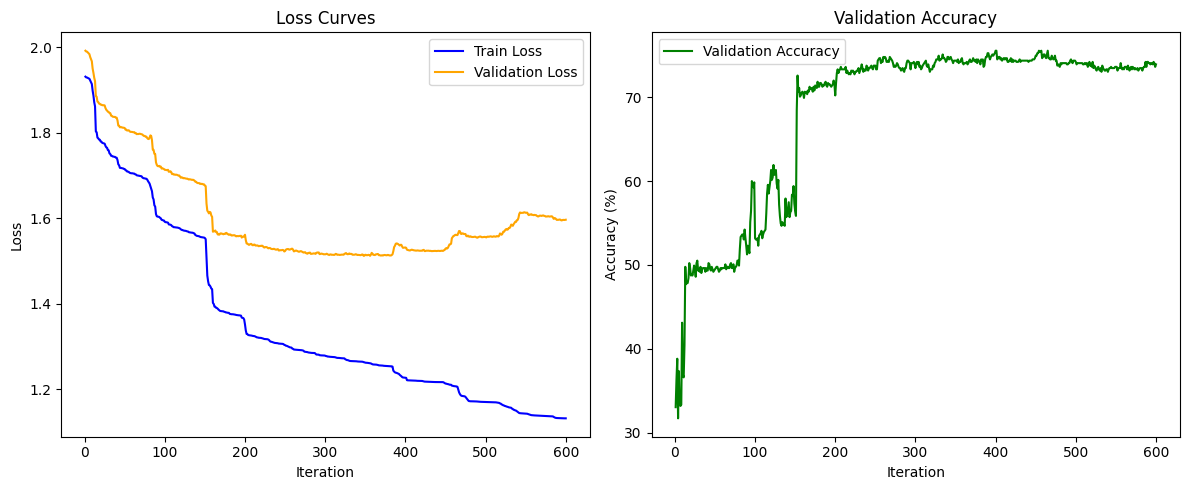

'\n%\n45.3      train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)\n43.8      y_pred_train = predict(Theta1, Theta2, X)\n'

In [15]:


def main():
    """ Artificial Neural Network for classifying galaxies """
    global N_iter, J_min, theta_best, Js_train, Js_test, Acc_train, Acc_test
    
    # Reset global tracking variables
    N_iter = 1
    J_min = np.inf
    theta_best = None
    Js_train = []
    Js_test = []
    Acc_train = []
    Acc_test = []

    # Network parameters
    input_layer_size = X.shape[1]
    hidden_layer_size = 8
    num_labels = 3
    lmbda = 1.0  # regularization parameter

    print("Input layer size:", input_layer_size)

    # Initialize random weights (use fixed seed for reproducibility)
    np.random.seed(42)
    Theta1 = np.random.rand(hidden_layer_size, input_layer_size + 1) * 0.4 - 0.2
    Theta2 = np.random.rand(num_labels, hidden_layer_size + 1) * 0.4 - 0.2

    # Flatten initial guess
    theta0 = np.concatenate((Theta1.flatten(), Theta2.flatten()))

    # Initial cost
    J_init = cost_function(theta0, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    print('Initial cost function J =', J_init)

    # Initial accuracy
    train_pred_init = predict(Theta1, Theta2, X)
    init_acc = 100.0 * np.sum(train_pred_init == y) / len(y)
    print('Initial accuracy on training set =', init_acc)

    # Minimize the cost function using a nonlinear conjugate gradient algorithm
    import time
    start_time = time.time()
    
    # Set up the optimization using the optimized gradient_cython function
    args = (input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
    cbf = partial(callbackF, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda, X_val, y_val)
    
    # Use the Cython optimized gradient function
    print("y dtype:", y.dtype)  # Should print int32
    optimize.fmin_cg(cost_function, theta0, fprime=gradient_cython, args=args, callback=cbf, maxiter=600)

    # Retrieve best found parameters
    if theta_best is None:
        # If no update happened, just use final
        theta_best_local = theta0
    else:
        theta_best_local = theta_best

    # Unflatten final/best theta
    Theta1_best, Theta2_best = reshape(theta_best_local, input_layer_size, hidden_layer_size, num_labels)

    # Final training and test predictions
    train_pred = predict(Theta1_best, Theta2_best, X)
    test_pred = predict(Theta1_best, Theta2_best, X_val)

    final_train_acc = 100.0 * np.sum(train_pred == y) / len(y)
    final_test_acc = 100.0 * np.sum(test_pred == y_val) / len(y_val)

    print(f"Final training accuracy = {final_train_acc:.2f}%")
    print(f"Final test accuracy     = {final_test_acc:.2f}%")
    
    elapsed_time = time.time() - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    # --- Plot at the end ---
    iters = np.arange(1, len(Js_train) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(iters, Js_train, label="Train Loss", color="blue")
    plt.plot(iters, Js_test, label="Validation Loss", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iters, Acc_test, label="Validation Accuracy", color="green")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("artificialneuralnetwork.png", dpi=240)
    plt.show()
    return 0


# OBS, the following results are from before the use of Cython
#%load_ext line_profiler 
main()
#%lprun -f main main()

# Profile cost_function
# %lprun -f cost_function main()
# Takes approx 2.5 seconds of 25 seconds execution time so 10% of total main function run time (100 training iterations) for one main run, the following two lines takes most of the compute:
# %
# 80.6      a1 = np.hstack((np.ones((m,1)), X)
# 14.0      a2 = g(a1 @ Theta1.T)

# Profile gradient
# %lprun -f gradient main()
# Not this is the main function taking up time, ran for 22.6127 s of a total main function execution time of 28.4 seconds for one main run, about 80% of total training loop computation!
# The following lines took up most of the compute:
""" Backpropagation                         %
   105    526695    1264976.0      2.4      0.6      for t in range(m):
   106                                                   # forward
   107    526500    3999422.0      7.6      1.8          a1 = X[t,:].reshape((input_layer_size,1))
   108    526500   44814604.0     85.1     19.8          a1 = np.vstack((1, a1))  # +bias
   109    526500   10094323.0     19.2      4.5          z2 = Theta1 @ a1
   110    526500   13165740.0     25.0      5.8          a2 = g(z2)
   111    526500   40686589.0     77.3     18.0          a2 = np.vstack((1, a2))  # +bias
   112    526500   17704636.0     33.6      7.8          a3 = g(Theta2 @ a2)
   113                                           
   114                                                   # one-hot
   115    526500    2678032.0      5.1      1.2          y_k = np.zeros((num_labels,1))
   116    526500    4534412.0      8.6      2.0          y_k[int(y[t,0])] = 1
   117                                                   # compute error for layer 3
   118    526500    3059709.0      5.8      1.4          delta3 = a3 - y_k
   119    526500    7737340.0     14.7      3.4          Delta2 += (delta3 @ a2.T)
   120                                           
   121                                                   # compute error for layer 2
   122    526500   27882635.0     53.0     12.3          delta2 = (Theta2[:,1:].T @ delta3) * grad_g(z2)
   123    526500   48369210.0     91.9     21.4          Delta1 += (delta2 @ a1.T)

"""
# So about 80% of our total computation time for training is spent within the backpropogation loop. This is what is expected when training a MLP as the forward pass is way less 
# computationally heavy in comparisson to the backwards pass.


# Profile callbackF
# %lprun -f callbackF main()
# Ran for 2.01368 s out of 26.8 s total execution time for one main run, so a smaller portion of the execution time. The following lines where using the compute:
"""
%
45.3      train_cost = cost_function(theta_k, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)
43.8      y_pred_train = predict(Theta1, Theta2, X)
"""

# OVERALL, the math done within the backpropagation loop within the gradient function is taking up more than 4/5 computational time. 
# Now within the backprop we must speed up the np.vstack calls and other matrix multiplications which shown in the profiling is what is taking so much time within the backpropagation within the gradient function
# 